<a href="https://colab.research.google.com/github/flavioschneider/bachelorthesis/blob/master/GRU_placecells_dropout_path_firing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Jupiter settings
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
!pip install livelossplot

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
import math 
from scipy.stats import multivariate_normal



# Position Encoder

Activation of cell 1: 	 0.00
Activation of cell 2: 	 0.00
Activation of cell 3: 	 0.00
Activation of cell 4: 	 0.02
Activation of cell 5: 	 0.00
Activation of cell 6: 	 0.00
Activation of cell 7: 	 0.00
Activation of cell 8: 	 0.00
Activation of cell 9: 	 0.00
Activation of cell 10: 	 0.00
Activation of cell 11: 	 0.01
Activation of cell 12: 	 0.00
Activation of cell 13: 	 0.00
Activation of cell 14: 	 0.00
Activation of cell 15: 	 0.00
Activation of cell 16: 	 0.00
Activation of cell 17: 	 0.00
Activation of cell 18: 	 0.00
Activation of cell 19: 	 0.00
Activation of cell 20: 	 0.00
Activation of cell 21: 	 0.01
Activation of cell 22: 	 0.00
Activation of cell 23: 	 0.00
Activation of cell 24: 	 0.00
Activation of cell 25: 	 0.03
Activation of cell 26: 	 0.00
Activation of cell 27: 	 0.00
Activation of cell 28: 	 0.02
Activation of cell 29: 	 0.00
Activation of cell 30: 	 0.02
Activation of cell 31: 	 0.00
Activation of cell 32: 	 0.00


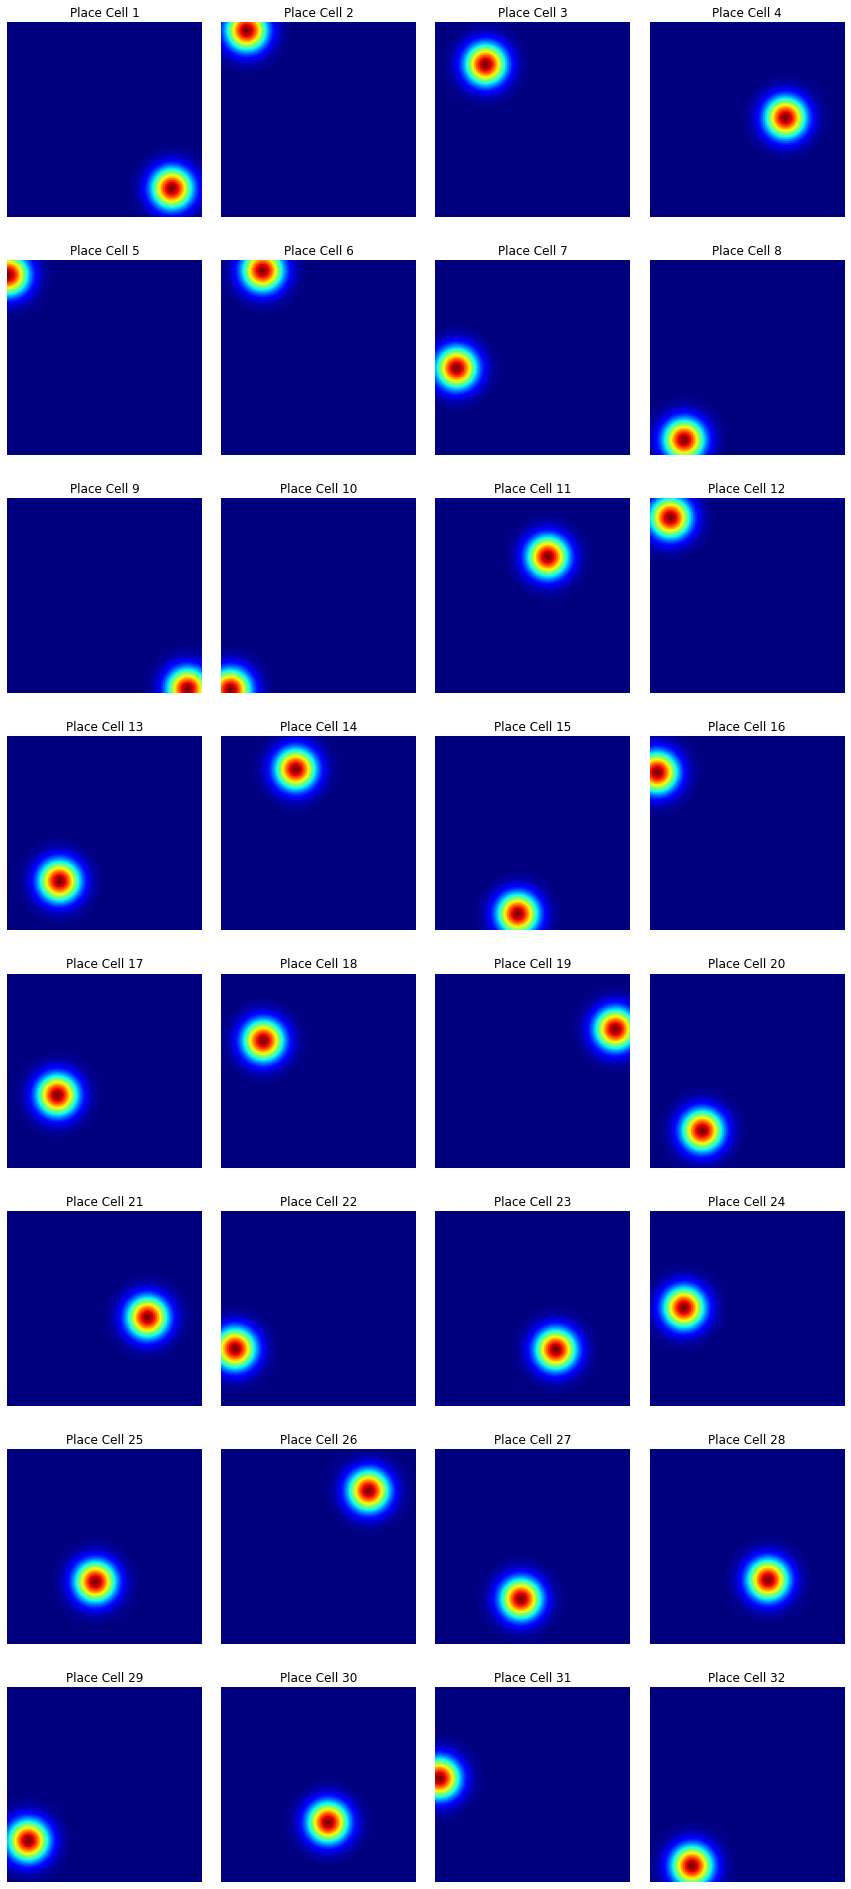

In [0]:
class PositionEncoder(): 

    def __init__(self, res=100, std=0.01, dim=96):
        """
        Parameters
        ----------
        res : int
            The resolution of the arena
        std : float
            The standard deviation of each position center activation        
        std: int  
            The encoding dimension (number of place cells)
        """
        self.res = res
        self.std = std 
        self.dim = dim 
        self.points = self.compute_eval_points([0,1])
        # Center mean points of the gaussians. 
        self.means = means = np.random.rand(self.dim, 2)
        # Place cells activations, precomputed for both speed and visualization.
        self.grids = self.precompute_activations()

    def compute_eval_points(self, range):
        """
        Computes an array of evaluation points of the 2D grid with a size of 
        (res**2, 2).
        """
        x = np.linspace(range[0], range[1], self.res)
        y = np.linspace(range[0], range[1], self.res)
        xx, yy = np.meshgrid(x,y)
        return np.c_[xx.ravel(), yy.ravel()]

    def precompute_activations(self): 
        """
        Evaluates random means and returns a tensor (dim, res, res) with 
        activation values in range [0,1]. 
        """
        grids = np.zeros((self.dim, self.res, self.res))
        cov = np.diag(np.repeat(self.std, 2))

        for i in range(self.dim):
            gaussian = multivariate_normal(mean=self.means[i], cov=cov)
            grids[i] = gaussian.pdf(self.points).reshape((self.res, self.res))
            grids[i] = grids[i] / np.max(grids[i])
    
        return grids;

    def display_grids(self):
        COLS = 4;
        fig, axs = plt.subplots(self.dim//COLS, COLS, figsize=(15, 35))
        i = 0
        for ax in axs.flat:
            ax.imshow(self.grids[i], cmap="jet")
            ax.set_title("Place Cell %s"%(i+1))
            ax.axis('off')
            ax.set_aspect('equal')
            i+=1

        fig.subplots_adjust(wspace=0.1, hspace=0)
    
    def get_grids(self):
        return self.grids

    def get_dim(self):
        return self.dim

    def encode_positions(self, positions):
        """
        Given an array of size (N,2) with values in [0,1] will return
        an array of size (N,D) with values in [0,1]. 
        """
        positions = np.clip(np.multiply(positions, self.res).astype(int), 0, 99); # [[50, 50], [10, 20]]
        N = positions.shape[0]; 
        encoded = np.zeros((N, self.dim))

        for i in range(N):
            encoded[i] = self.grids[:, positions[i,0], positions[i,1]]

        return encoded;


"""
Example: we take the middle point [0.5,0.5] and check the activation of each cell.
""" 
position_encoder = PositionEncoder(std=0.005, dim=32)
grids = position_encoder.get_grids()
position_encoder.display_grids() 
np.set_printoptions(precision=3, suppress=True)
input = [[0.5, 0.5], [0.1, 0.2]]
output = position_encoder.encode_positions(input)
for i in range(output.shape[1]):
    print("Activation of cell %s: \t %1.2f" % (i+1, output[0,i]))


# Path Simulator


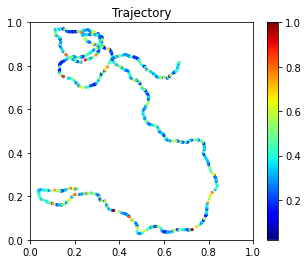

In [0]:
class PathSimulator():
    def __init__(self):
        self.dt=0.05
        self.maxGap=1-self.dt
        self.minGap=self.dt

        self.velScale = 0.13
        self.mAngVel = 0
        self.stddevAngVel = 330

        self.pos = np.random.uniform(low=self.minGap, high=self.maxGap, size=(2)) #np.random.uniform(low=self.minGap, high=self.maxGap, size=(2))
        self.facAng = np.random.uniform(low=-np.pi, high=np.pi)
        self.prevVel = 0

    def generateTrajectory(self, agent_steps=500, agent_new=False, room_size=1, room_walls=4, room_rotation=0):
        if agent_new:
            self.pos = np.random.uniform(low=self.minGap, high=self.maxGap, size=(2))
            self.facAng = np.random.uniform(low=-np.pi, high=np.pi)
            self.prevVel = 0

        velocities = np.zeros((agent_steps))
        angVel = np.zeros((agent_steps))
        positions = np.zeros((agent_steps, 2))
        angle = np.zeros((agent_steps))

        for t in range(agent_steps):
            # pick random rotational velocity from a normal distribution with 0 mean and stddevAngVel standard deviation
            rotVel = np.deg2rad(np.random.normal(
                self.mAngVel, self.stddevAngVel))
            # Check if the agent is near a wall
            if(self.checkWallAngle(self.facAng, self.pos, room_size, room_walls, room_rotation)):
                # if True, compute in which direction turning by 90 deg
                dAngle = self.computeRot(self.facAng, self.pos) + rotVel*self.dt
                # Velocity reduction factor
                vel = np.squeeze(self.prevVel - (self.prevVel*0.25))
            # If the agent is not near a wall, randomly sampling velocity and angVelocity
            else:
                # Sampling angular velocity
                dAngle = rotVel*self.dt
                # Sampling velocity
                vel = np.random.rayleigh(self.velScale)

            # Update the position of the agent
            newPos = self.pos + \
                (np.asarray([np.cos(self.facAng),
                             np.sin(self.facAng)])*vel)*self.dt

            # Update the facing angle of the agent
            newFacAng = (self.facAng + dAngle)
            # Keep the orientation between -np.pi and np.pi
            if(np.abs(newFacAng) >= (np.pi)):
                newFacAng = -1*np.sign(newFacAng) * \
                    (np.pi - (np.abs(newFacAng) - np.pi))

            velocities[t] = vel
            angVel[t] = rotVel
            positions[t] = self.pos
            angle[t] = self.facAng

            self.pos = newPos
            self.facAng = newFacAng
            self.prevVel = vel

        return velocities, angVel, positions, angle

    # HELPING FUNCTIONS
    def checkWallAngle(self, ang, pos, r_size, r_walls, r_rot):
        #print("Rat orientation:", ang)
        if((0 <= ang and ang <= (np.pi/2)) and np.any(pos > self.maxGap)):
            return True
        elif((ang >= (np.pi/2) and ang <= np.pi) and (pos[0] < self.minGap or pos[1] > self.maxGap)):
            return True
        elif((ang >= -np.pi and ang <= (-np.pi/2)) and np.any(pos < self.minGap)):
            return True
        elif((ang >= (-np.pi/2) and ang <= 0) and (pos[0] > self.maxGap or pos[1] < self.minGap)):
            return True
        else:
            return False

    def computeRot(self, ang, pos):
        rot = 0
        if(ang >= 0 and ang <= (np.pi/2)):
            if(pos[1] > self.maxGap):
                rot = -ang
            elif(pos[0] > self.maxGap):
                rot = np.pi/2-ang
        elif(ang >= (np.pi/2) and ang <= np.pi):
            if(pos[1] > self.maxGap):
                rot = np.pi-ang
            elif(pos[0] < self.minGap):
                rot = np.pi/2 - ang
        elif(ang >= -np.pi and ang <= (-np.pi/2)):
            if(pos[1] < self.minGap):
                rot = -np.pi - ang
            elif(pos[0] < self.minGap):
                rot = -(ang + np.pi/2)
        else:
            if(pos[1] < self.minGap):
                rot = -ang
            elif(pos[0] > self.maxGap):
                rot = (-np.pi/2) - ang

        return rot

"""
Example
"""

def plot_paths(x, y, z, x_pred=[], y_pred=[], text="Trajectory"):
    fig = plt.figure(figsize=(5,4))
    fig.add_axes();
    ax = fig.add_subplot(111)
    ax.set_title(text)
    plt.xlim(0,1)
    plt.ylim(0,1)
    sc = ax.scatter(x, y, c=z, s=5, cmap='jet', alpha=0.9)
    fig.colorbar(sc, ax=ax)
    sc = ax.scatter(x_pred, y_pred, s=5, alpha=0.6, color='blue')

simulator = PathSimulator()
velocities, angVel, positions, angle = simulator.generateTrajectory(500, agent_new=True)
plot_paths(positions[:,0], positions[:,1], velocities/velocities.max(axis=0))

# Firing Visualizer
Given a set of 2D positions in (0,1) and a set of higher dimensional states that should encode the position (e.g. hidden layer of a NN or RNN) we can visualize how each cell in the state is active in _all_ positions by averaging all the information. 

In [0]:
class FiringVisualizer():
    def __init__(self, res=100):
        self.res = res;
    """
    positions of size (SAMPLES, 2)
    states of size (SAMPLES, DIM)
    """
    def visualize(self, positions, states, title=""):  
        samples = states.shape[0]
        dim = states.shape[1]

        """
        The rate stores for each sample how much is active in each cell for all 
        points selected, if a point is picked more than once in the same cell the rate
        is higher, thus we have to count how many times 
        """
        rate = np.zeros([dim, self.res, self.res]) 
        count = np.zeros([self.res, self.res])

        print("Evaluating activation rates...")
        for unit in range(dim):
            for step in range(samples):
                x = positions[step, 0] * self.res 
                y = positions[step, 1] * self.res 
                if(int(x) >= self.res or int(y) >= self.res): continue 
                count[int(x), int(y)] += 1
                rate[unit, int(x), int(y)] += np.abs(states[step, unit])
            print("Unit %s/%s"%(unit+1, dim))

        print("Normalizing...")     
        for x in range(self.res):
            for y in range(self.res):
                if count[x, y] > 0:
                    rate[:, x, y] /= count[x, y]

        print("Plotting...")
        columns = dim // 8
        fig, axs = plt.subplots(columns, 8, figsize=(16, 2*columns))
        fig.suptitle(title) #'Description: %s \nI: %s, H: %s, O: %s, STD: %s, LR: %s, L2: %s, R1: %s, RA: %s, RD: %s, N: %s'%(DESCRIPTION, INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, PLACE_CELLS_STD, LR,L2,R1,RA,RD,NOISE))
        i = 0
        for ax in axs.flat:
            ax.imshow(rate[i,:,:] / np.max(rate[i,:,:]), interpolation="nearest", cmap="jet")
            ax.axis('off')
            ax.set_aspect('equal')
            i+=1

        fig.subplots_adjust(wspace=0.1, hspace=0)
        return rate 



# Datasets

### Decoder Dataset
Used to train a decoder that given the place cells firing values returns the 2D (x,y) position.

### Path Dataset
Used to train the path-integrator, that given the initial encoded position and at each timestep the velocity and angle (direction) finds the new encoded position.


In [0]:
class DecoderDataset(torch.utils.data.Dataset):

    def __init__(self, encoder, samples): 
        self.encoder = encoder
        self.samples = samples
        self.points = np.zeros((samples, 2))    
        self.encoding = np.zeros((samples, encoder.get_dim()))

    def __len__(self):
        return self.samples

    """
    Each sample contains:
    - A random (x,y) position of size (2).
    - The analog encoded position of size (ENC_DIM).
    """
    def __getitem__(self, idx):
        if self.points[idx, 0] == 0:
            self.points[idx] = np.random.uniform(low=0, high=1, size=(2))
            self.encoding[idx] = self.encoder.encode_positions([self.points[idx]])[0]
        return self.points[idx], self.encoding[idx]


class PathsDataset(torch.utils.data.Dataset):
    
    def __init__(self, encoder, simulator, samples, length): 
        self.encoder = encoder 
        self.simulator = simulator; 
        self.samples = samples
        self.length = length 
        self.enc_dim = encoder.get_dim()

        self.start_pos_data = np.zeros((samples, 2))
        self.start_pos_encoded_data = np.zeros((samples, self.enc_dim))  

        self.input_data = np.zeros((samples, length, 3))

        self.pos_data = np.zeros((samples, length, 2))
        self.pos_encoded_data = np.zeros((samples, length, self.enc_dim))

    def __len__(self):
        return self.samples

    """
    Each sample contains:
    - Initial encoded position of size (ENC_DIM).
    - The time input data with velocity and cos/sin of the angle of size (SEQ_LEN, 3).
    - The time output data with the encoded position of size (SEQ_LEN, ENC_DIM).
    """
    def __getitem__(self, idx):
        if self.start_pos_encoded_data[idx, 0] == 0:
            v, _, pos, a = simulator.generateTrajectory(self.length+1, agent_new=True)
            self.start_pos_data[idx] = pos[0] 
            self.start_pos_encoded_data[idx] = self.encoder.encode_positions([pos[0]])
            self.input_data[idx] = np.stack((v[:-1], np.cos(a[:-1]), np.sin(a[:-1])), axis=-1)
            self.pos_encoded_data[idx] = self.encoder.encode_positions(pos[1:]) 
            self.pos_data[idx] = pos[1:]
        return self.start_pos_data[idx], self.start_pos_encoded_data[idx], self.input_data[idx], self.pos_data[idx], self.pos_encoded_data[idx]

class AutoencoderDataset(torch.utils.data.Dataset):

    def __init__(self, encoder, samples): 
        self.encoder = encoder
        self.samples = samples  
        self.encoding = np.zeros((samples, encoder.get_dim()))

    def __len__(self):
        return self.samples

    """
    Each sample contains:
    - An encoded position of size (ENC_DIM).
    """
    def __getitem__(self, idx):
        if self.encoding[idx, 0] == 0:
            self.encoding[idx] = self.encoder.encode_positions([np.random.uniform(low=0, high=1, size=(2))])[0]
        return self.encoding[idx]

# Models

Defaults

In [0]:
ENCODER_PLACE_CELLS = 96
ENCODER_STD = 0.01
FIRING_RESOLUTION = 100

encoder = PositionEncoder(std=ENCODER_STD, dim=ENCODER_PLACE_CELLS)
path_simulator = PathSimulator()
firing_visualizer = FiringVisualizer(FIRING_RESOLUTION)
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Decoder Model

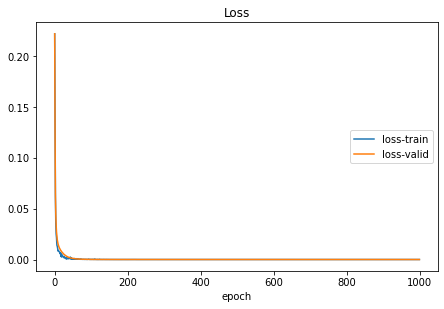

Loss
	loss-train       	 (min:    0.000, max:    0.222, cur:    0.000)
	loss-valid       	 (min:    0.000, max:    0.222, cur:    0.000)
Iter: 1000/1000, Training Loss: 1.3291316463437397e-05, Validation Loss: 1.2930488082929514e-05


In [0]:
DECODER_LEARNING_RATE = 0.0001
DECODER_TRAIN_ITERATIONS = 1000
DECODER_BATCH_SIZE = 128 
DECODER_TRAIN_SAMPLES = 12800
DECODER_VALID_SAMPLES = 1280
DECODER_MODEL_PATH = './decoder.pt'

DECODER_INPUT_DIM = ENCODER_PLACE_CELLS
DECODER_HIDDEN_DIM = 48
DECODER_OUTPUT_DIM = 2 

class DecoderModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DecoderModel, self).__init__() 
        self.input_dim = input_dim        
        self.hidden_dim = hidden_dim        
        self.output_dim = output_dim        
        self.input_layer = nn.Linear(input_dim, hidden_dim)    
        self.output_layer = nn.Linear(hidden_dim, output_dim)    
        self.relu = nn.ReLU() 

    def forward(self, inputs):
        hidden = self.input_layer(inputs)
        states = self.relu(hidden)
        outputs = self.output_layer(states)
        return outputs, states

decoder_model = DecoderModel(DECODER_INPUT_DIM, DECODER_HIDDEN_DIM, DECODER_OUTPUT_DIM)
decoder_model.to(dev)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(decoder_model.parameters(), lr=DECODER_LEARNING_RATE)
decoder_dataset = DecoderDataset(encoder, DECODER_TRAIN_SAMPLES + DECODER_VALID_SAMPLES)
decoder_train_set, decoder_valid_set = torch.utils.data.random_split(
    decoder_dataset, 
    [DECODER_TRAIN_SAMPLES, DECODER_VALID_SAMPLES]
)
decoder_train_loader = torch.utils.data.DataLoader(
    decoder_train_set, 
    batch_size=DECODER_BATCH_SIZE, 
    shuffle=True
)
decoder_val_loader = torch.utils.data.DataLoader(
    decoder_valid_set, 
    batch_size=DECODER_BATCH_SIZE, 
    shuffle=False
)

groups = {'Loss': ['loss-train', 'loss-valid']}
decoder_plotlosses = PlotLosses(groups=groups)

for iter in range(DECODER_TRAIN_ITERATIONS):
    loss_train = None 
    loss_valid = None

    for idx, (position, position_encoded)  in enumerate(decoder_train_loader):
        position = position.float().to(dev)
        position_encoded = position_encoded.float().to(dev)
        optimizer.zero_grad()
        position_predicted, _ = decoder_model(position_encoded)
        loss_train = criterion(position_predicted, position)
        loss_train.backward()
        optimizer.step() 

    for idx, (position, position_encoded) in enumerate(decoder_val_loader):
        position = position.float().to(dev)
        position_encoded = position_encoded.float().to(dev)
        position_predicted, _ = decoder_model(position_encoded)
        loss_valid = criterion(position_predicted, position)

    decoder_plotlosses.update({'loss-train': loss_train.item(), 'loss-valid': loss_valid.item()})
    decoder_plotlosses.send()
    print('Iter: %s/%s, Training Loss: %s, Validation Loss: %s' % (
        iter+1, 
        DECODER_TRAIN_ITERATIONS, 
        loss_train.item(), 
        loss_valid.item()
        )
    )

torch.save(decoder_model.state_dict(), DECODER_MODEL_PATH)

In [0]:
"""
Example: we encode a single position and then decode it using our decoder model. 
"""
position = [0.8, 0.3] 
position_encoded = torch.Tensor(encoder.encode_positions([position])[0]).float().to(dev).unsqueeze(0)
position_predicted, _ = decoder_model(position_encoded)
print(position_predicted)

tensor([[0.8048, 0.3045]], device='cuda:0', grad_fn=<AddmmBackward>)


### Decoder Hidden Layer Visualization
We check the firing pattern that the hidden layer in the decoder neural network.

Evaluating activation rates...
Unit 1/48
Unit 2/48
Unit 3/48
Unit 4/48
Unit 5/48
Unit 6/48
Unit 7/48
Unit 8/48
Unit 9/48
Unit 10/48
Unit 11/48
Unit 12/48
Unit 13/48
Unit 14/48
Unit 15/48
Unit 16/48
Unit 17/48
Unit 18/48
Unit 19/48
Unit 20/48
Unit 21/48
Unit 22/48
Unit 23/48
Unit 24/48
Unit 25/48
Unit 26/48
Unit 27/48
Unit 28/48
Unit 29/48
Unit 30/48
Unit 31/48
Unit 32/48
Unit 33/48
Unit 34/48
Unit 35/48
Unit 36/48
Unit 37/48
Unit 38/48
Unit 39/48
Unit 40/48
Unit 41/48
Unit 42/48
Unit 43/48
Unit 44/48
Unit 45/48
Unit 46/48
Unit 47/48
Unit 48/48
Normalizing...
Plotting...


array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.006, 0.006, 0.006, ..., 0.004, 0.004, 0.004],
        [0.006, 0.006, 0.006, ..., 0.004, 0.004, 0.004],
        [0.006, 0.006, 0.006, ..., 0.004, 0.004, 0.004]],

       [[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.007, 0.007, 0.007, ..., 0.007, 0.007, 0.007],
        [0.007, 0.007, 0.007, ..., 0.007, 0.007, 0.007],
        [0.007, 0.007, 0.007, ..., 0.007, 0.007, 0.007]],

       [[0.004, 0.004, 0.004, ..., 0.001, 0.001, 0.001],
        [0.004, 0.004, 0.004, ..., 0.001, 0.001, 0.001],
        [0.004, 0.004, 0.004, ..., 0.001, 0.001, 0.001],
        ...,
        [0.007, 0.008, 0.008, ..., 0.   , 0.   , 0.   ],
        [0.007, 0.007, 0.008, ..., 0.   , 0. 

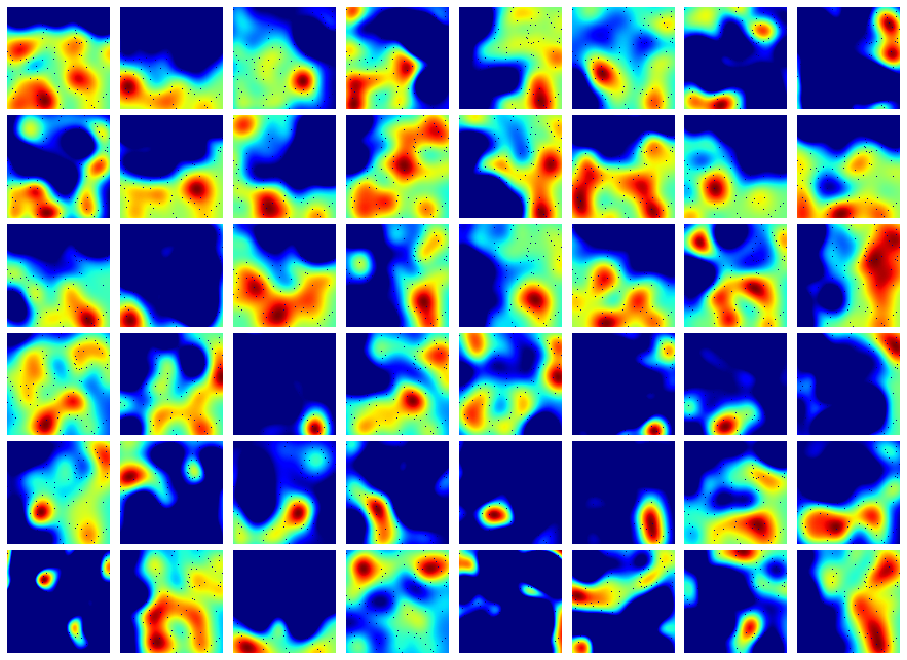

In [0]:
decoder_model.eval()
# Check activations of hidden units
DECODER_VISUALIZATION_NUM_SAMPLES = 50000

decoder_test_dataset = DecoderDataset(encoder, DECODER_VISUALIZATION_NUM_SAMPLES)
decoder_test_loader = torch.utils.data.DataLoader(decoder_test_dataset, batch_size=DECODER_VISUALIZATION_NUM_SAMPLES)

idx, (position, position_encoded) = list(enumerate(decoder_test_loader))[0]
position_encoded = position_encoded.float().to(dev)
position_predicted, hidden_layer = decoder_model(position_encoded)

hidden_layer = hidden_layer.detach().cpu().numpy()
firing_visualizer.visualize(position, hidden_layer, "")

### RNN1 (GRU) Model Path Integration

We try to see whether we can get more structured spots (i.e. gridlike) if instead of just decoding the position from place cells we do path integration.


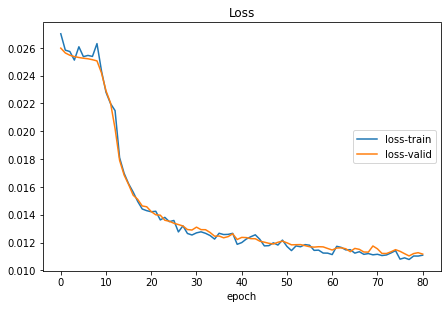

Loss
	loss-train       	 (min:    0.011, max:    0.027, cur:    0.011)
	loss-valid       	 (min:    0.011, max:    0.026, cur:    0.011)
Iter: 81/1500, Training Loss: 0.011091817170381546, Validation Loss: 0.011173008941113949


In [0]:
RNN_LEARNING_RATE = 0.0001
RNN_TRAIN_ITERATIONS = 1500
RNN_BATCH_SIZE = 64
RNN_TRAIN_SAMPLES = 4096
RNN_VALID_SAMPLES = 256
RNN_SEQ_LENGTH = 300
RNN_MODEL_PATH = './rnn.pt'

RNN_ENC_DIM = ENCODER_PLACE_CELLS
RNN_INPUT_DIM = 3 
RNN_HIDDEN_DIM = 128
RNN_PROJ_DIM = 512

RNN_DROPOUT = 0.5

class RNNModel(nn.Module):

    def __init__(self, enc_dim, input_dim, hidden_dim, dropout):
        super(RNNModel, self).__init__()  
        self.enc_dim = enc_dim  
        self.input_dim = input_dim     
        self.hidden_dim = hidden_dim  
        self.start_to_hidden_layer = nn.Linear(enc_dim, hidden_dim)
        self.gru_layer = nn.GRU(input_size=input_dim, hidden_size=hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, RNN_PROJ_DIM)
        self.hidden_to_output = nn.Linear(RNN_PROJ_DIM, enc_dim)
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(dropout)

    """
    start is of size:   (BATCH_SIZE, ENC_DIM)
    inputs is of size:  (SEQ_LENGTH, BATCH_SIZE, INPUT_DIM)
    states if of size:  (SEQ_LENGTH, BATCH_SIZE, HIDDEN_DIM)
    outputs if of size: (SEQ_LENGTH, BATCH_SIZE, ENC_DIM)
    """
    def forward(self, start, inputs):
        hidden = self.start_to_hidden_layer(start).unsqueeze(0) 
        states, state = self.gru_layer(inputs, hidden) 
        states = self.dropout(states)
        projection = self.hidden_to_hidden(states)
        projection = self.relu(projection)
        projection = self.dropout(projection)
        outputs = self.hidden_to_output(projection)
        return outputs, states, projection

rnn_model = RNNModel(RNN_ENC_DIM, RNN_INPUT_DIM, RNN_HIDDEN_DIM, RNN_DROPOUT)
rnn_model.to(dev)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=RNN_LEARNING_RATE)
rnn_dataset = PathsDataset(encoder, path_simulator, RNN_TRAIN_SAMPLES + RNN_VALID_SAMPLES, RNN_SEQ_LENGTH)
rnn_train_set, rnn_valid_set = torch.utils.data.random_split(
    rnn_dataset, 
    [RNN_TRAIN_SAMPLES, RNN_VALID_SAMPLES]
)
rnn_train_loader = torch.utils.data.DataLoader(
    rnn_train_set, 
    batch_size=RNN_BATCH_SIZE, 
    shuffle=True
)
rnn_val_loader = torch.utils.data.DataLoader(
    rnn_valid_set, 
    batch_size=RNN_BATCH_SIZE, 
    shuffle=False
)

groups = {'Loss': ['loss-train', 'loss-valid']}
rnn_plotlosses = PlotLosses(groups=groups)

for iter in range(RNN_TRAIN_ITERATIONS):
    loss_train = None 
    loss_valid = None

    for idx, (start_pos, start_pos_encoded, inputs, pos, pos_encoded)  in enumerate(rnn_train_loader):
        #start_pos = start_pos.float().to(dev)
        start_pos_encoded = start_pos_encoded.float().to(dev)
        inputs = inputs.float().permute([1,0,2]).to(dev)
        pos = pos.float().permute([1,0,2]).to(dev)
        pos_encoded = pos_encoded.float().permute([1,0,2]).to(dev)
        optimizer.zero_grad()
        pos_encoded_predicted, _, proj = rnn_model(start_pos_encoded, inputs)
        #pos_predicted, _ = decoder_model(pos_encoded_predicted)  
        loss_train = criterion(pos_encoded_predicted, pos_encoded) 
        #loss_train += 0.0005 * (torch.abs(torch.sum(proj-torch.abs(proj))) / (RNN_BATCH_SIZE * RNN_PROJ_DIM))
        loss_train.backward()
        optimizer.step() 

    for idx, (start_pos, start_pos_encoded, inputs, pos, pos_encoded) in enumerate(rnn_val_loader):
        #start_pos = start_pos.float().to(dev)
        start_pos_encoded = start_pos_encoded.float().to(dev)
        inputs = inputs.float().permute([1,0,2]).to(dev)
        pos = pos.float().permute([1,0,2]).to(dev)
        pos_encoded = pos_encoded.float().permute([1,0,2]).to(dev)
        pos_encoded_predicted, _, _ = rnn_model(start_pos_encoded, inputs)
        #pos_predicted, _ = decoder_model(pos_encoded_predicted)  
        loss_valid = criterion(pos_encoded_predicted, pos_encoded) 

    rnn_plotlosses.update({'loss-train': loss_train.item(), 'loss-valid': loss_valid.item()})
    rnn_plotlosses.send()
    if(iter % 5 == 0):
        print('Iter: %s/%s, Training Loss: %s, Validation Loss: %s' % (
            iter+1, 
            RNN_TRAIN_ITERATIONS, 
            loss_train.item(), 
            loss_valid.item()
            )
        )

torch.save(rnn_model.state_dict(), RNN_MODEL_PATH)

### RNN1 Visualize Path Integration

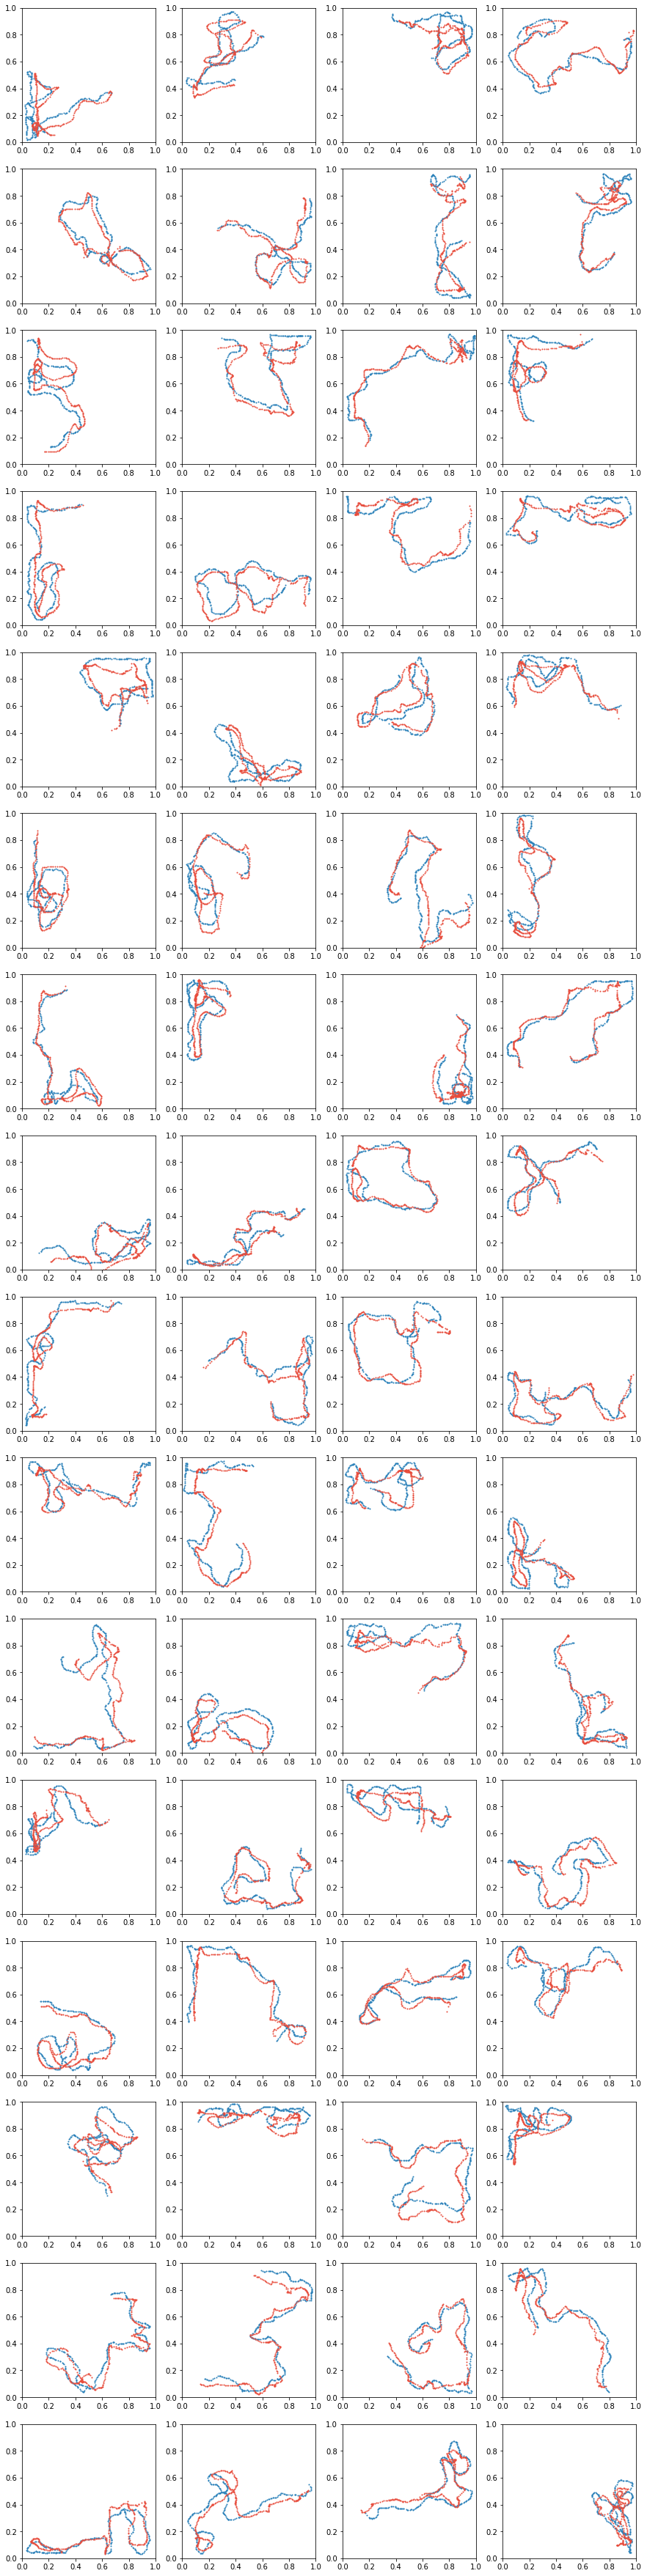

In [0]:
rnn_model.eval()
# Pick one batch from the validation set.
idx, (start_pos, start_pos_encoded, inputs, pos, pos_encoded) = list(enumerate(rnn_val_loader))[0]
# Feed it to the model.
start_pos = start_pos.float().to(dev)
start_pos_encoded = start_pos_encoded.float().to(dev)
inputs = inputs.float().permute([1,0,2]).to(dev)
pos_encoded_predicted, _, _ = rnn_model(start_pos_encoded, inputs)     
pos_predicted, _ = decoder_model(pos_encoded_predicted)     
# Plot the real and the predicted paths. 
pos = pos.detach().cpu().numpy()
pos_predicted = pos_predicted.permute([1,0,2]).detach().cpu().numpy() 

columns = 16
fig, axs = plt.subplots(columns, 4, figsize=(15, 4*columns))
i = 0
for ax in axs.flat:
    x_real = pos[i,:,0] 
    y_real = pos[i,:,1] 
    x_pred = pos_predicted[i,:,0] 
    y_pred = pos_predicted[i,:,1] 
    ax.scatter(x_real, y_real, s=1, color="#2980b9")
    ax.scatter(x_pred, y_pred, s=1,  color='#e74c3c')
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    i+=1

## RNN1 Hidden Layer Visualization

torch.Size([300, 300, 2])
torch.Size([300, 300, 128])
(90000, 2)
(90000, 128)
Evaluating activation rates...
Unit 1/128
Unit 2/128
Unit 3/128
Unit 4/128
Unit 5/128
Unit 6/128
Unit 7/128
Unit 8/128
Unit 9/128
Unit 10/128
Unit 11/128
Unit 12/128
Unit 13/128
Unit 14/128
Unit 15/128
Unit 16/128
Unit 17/128
Unit 18/128
Unit 19/128
Unit 20/128
Unit 21/128
Unit 22/128
Unit 23/128
Unit 24/128
Unit 25/128
Unit 26/128
Unit 27/128
Unit 28/128
Unit 29/128
Unit 30/128
Unit 31/128
Unit 32/128
Unit 33/128
Unit 34/128
Unit 35/128
Unit 36/128
Unit 37/128
Unit 38/128
Unit 39/128
Unit 40/128
Unit 41/128
Unit 42/128
Unit 43/128
Unit 44/128
Unit 45/128
Unit 46/128
Unit 47/128
Unit 48/128
Unit 49/128
Unit 50/128
Unit 51/128
Unit 52/128
Unit 53/128
Unit 54/128
Unit 55/128
Unit 56/128
Unit 57/128
Unit 58/128
Unit 59/128
Unit 60/128
Unit 61/128
Unit 62/128
Unit 63/128
Unit 64/128
Unit 65/128
Unit 66/128
Unit 67/128
Unit 68/128
Unit 69/128
Unit 70/128
Unit 71/128
Unit 72/128
Unit 73/128
Unit 74/128
Unit 75/128


array([[[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.005, ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.005,  0.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   , -0.001, ...,  0.   ,  0.   ,  0.   ],
        [ 0.   , -0.001,  0.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]],

       [[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.004, ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.004,  0.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.

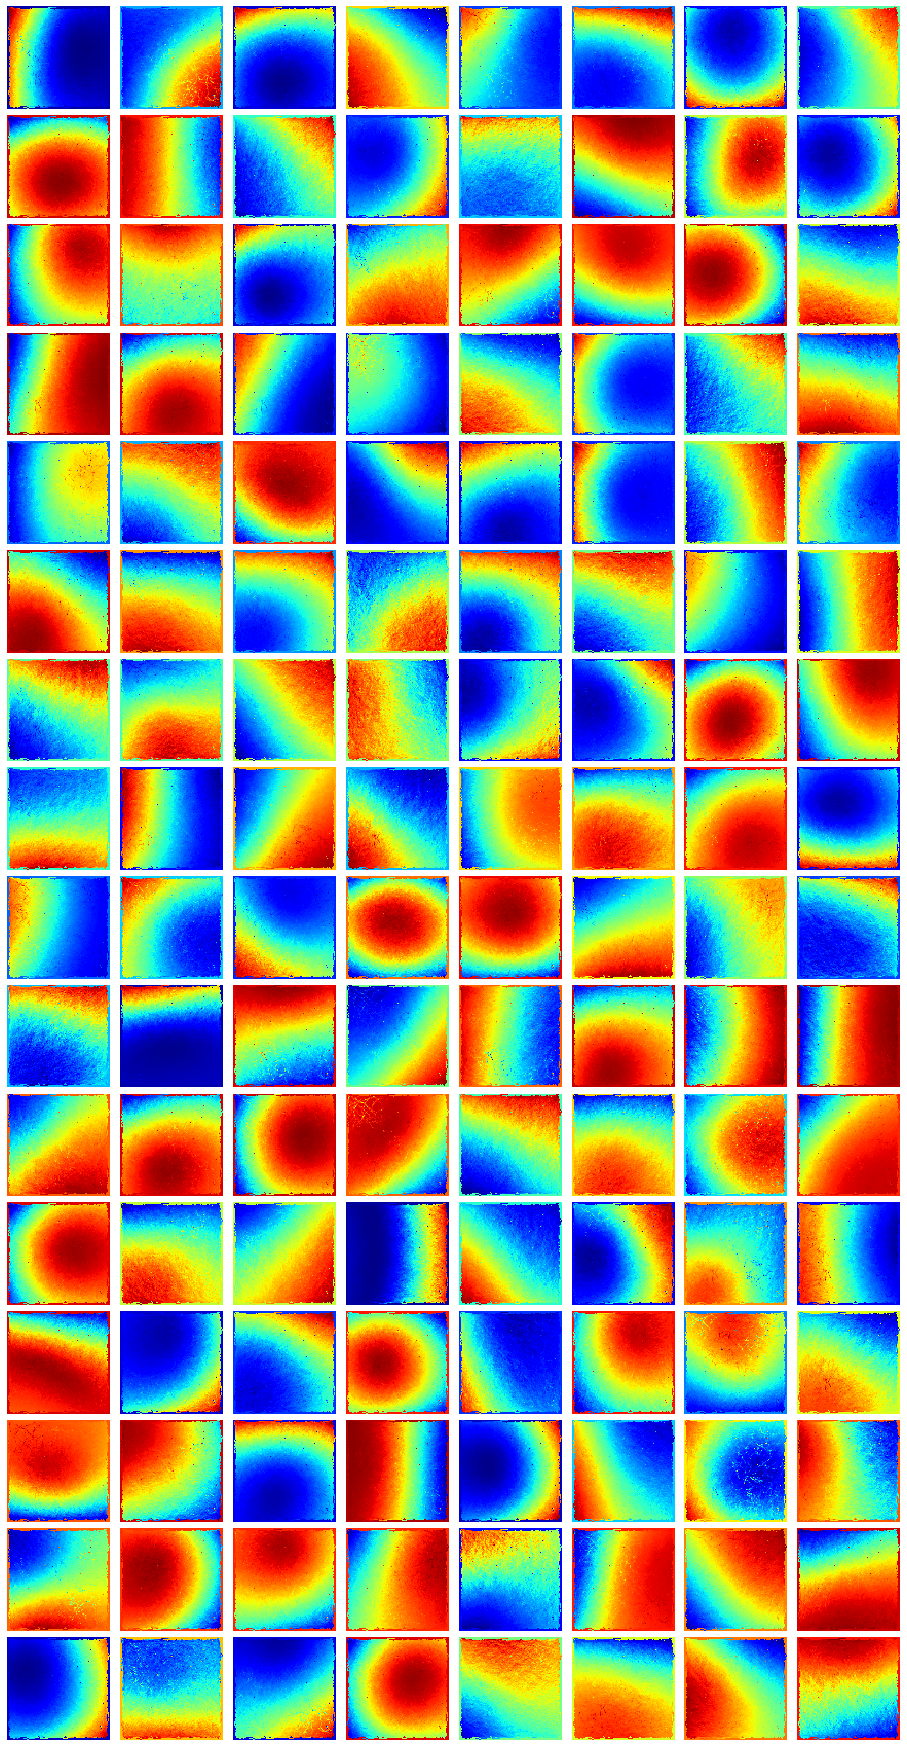

In [0]:
rnn_model.eval()
# Check activations of hidden units
RNN_VISUALIZATION_NUM_SAMPLES = 300 # Number of paths of length RNN_SEQ_LENGTH to generate.

rnn_visualization_dataset = PathsDataset(encoder, path_simulator, RNN_VISUALIZATION_NUM_SAMPLES, RNN_SEQ_LENGTH)
rnn_visualization_loader = torch.utils.data.DataLoader(rnn_visualization_dataset, batch_size=RNN_VISUALIZATION_NUM_SAMPLES)

idx, (_, start_pos_encoded, inputs, pos, _) = list(enumerate(rnn_visualization_loader))[0]
start_pos_encoded = start_pos_encoded.float().to(dev)
inputs = inputs.float().permute([1,0,2]).to(dev)
pos_encoded_predicted, hidden_layer, projection_layer = rnn_model(start_pos_encoded, inputs)     
pos_predicted, _ = decoder_model(pos_encoded_predicted)     

print(pos_predicted.shape)
print(hidden_layer.shape)

pos = pos.permute([1,0,2]).reshape(-1, 2).detach().cpu().numpy()
pos_predicted = pos_predicted.view(-1, 2).detach().cpu().numpy() 
pos_encoded_predicted = pos_encoded_predicted.view(-1, RNN_ENC_DIM).detach().cpu().numpy()
hidden_layer = hidden_layer.view(-1, RNN_HIDDEN_DIM).detach().cpu().numpy()
projection_layer = projection_layer.view(-1, RNN_PROJ_DIM).detach().cpu().numpy()

print(pos_predicted.shape)
print(hidden_layer.shape)
#print(projection_layer.shape)

firing_visualizer.visualize(pos, hidden_layer, "")

In [0]:
info = """
* Path Simulator Settings:
  dt =              0.05 
  velScale =        0.13
  arena:            [0,1]^2

* Position Encoding:
  place_cells =     %s
  std =             %s
  resolution =      %s

* Decoder Model Settings: 
  Info: Single layer neural network.
  learning_rate:    %s
  train_iterations: %s
  batch_size:       %s
  train_samples:    %s
  valid_samples:    %s
  input_dim:        %s
  hidden_dim:       %s
  output_dim        %s

* RNN Model Settings:
  Info: Initial hidden layer is trained from the encoded start position, 
        the input at each timestep is (velocity, cos(angle), sin(angle)),
        and the output is the encoded new position.
  learning_rate:    %s
  train_iterations: %s
  batch_size:       %s
  train_samples:    %s
  valid_samples:    %s
  seq_length:       %s 
  enc_dim:          %s
  input_dim:        %s
  hidden_dim:       %s
  projected_dim:    %s
  dropout:          %s 

* Visualization info:
  Projected pos:    Real,
  Projected vector: RNN Hidden Layer
  Num samples:      %s
  
""" % (
ENCODER_PLACE_CELLS,
ENCODER_STD,
FIRING_RESOLUTION,
DECODER_LEARNING_RATE,
DECODER_TRAIN_ITERATIONS,
DECODER_BATCH_SIZE,
DECODER_TRAIN_SAMPLES,
DECODER_VALID_SAMPLES,
DECODER_INPUT_DIM,
DECODER_HIDDEN_DIM,
DECODER_OUTPUT_DIM,
RNN_LEARNING_RATE,
RNN_TRAIN_ITERATIONS,
RNN_BATCH_SIZE,
RNN_TRAIN_SAMPLES,
RNN_VALID_SAMPLES,
RNN_SEQ_LENGTH,
RNN_ENC_DIM,
RNN_INPUT_DIM,
RNN_HIDDEN_DIM,
RNN_PROJ_DIM,
RNN_DROPOUT,
RNN_VISUALIZATION_NUM_SAMPLES
)

print(title)


* Path Simulator Settings:
  dt =              0.05 
  velScale =        0.13
  arena:            [0,1]^2

* Position Encoding:
  place_cells =     96
  std =             0.01
  resolution =      100

* Decoder Model Settings: 
  Info: Single layer neural network.
  learning_rate:    0.0001
  train_iterations: 100
  batch_size:       128
  train_samples:    12800
  valid_samples:    1280
  input_dim:        96
  hidden_dim:       48
  output_dim        2

* RNN Model Settings:
  Info: Initial hidden layer is trained from the encoded start position, 
        the input at each timestep is (velocity, cos(angle), sin(angle)),
        and the output is the encoded new position.
  learning_rate:    0.0001
  train_iterations: 1000
  batch_size:       128
  train_samples:    4096
  valid_samples:    256
  seq_length:       300 
  enc_dim:          96
  input_dim:        3
  hidden_dim:       128
  projected_dim:    512
  dropout:          0.5 

* Visualization info:
  Projected pos:    Real,


## RNN2 (GRU) Model Position Autoencoding

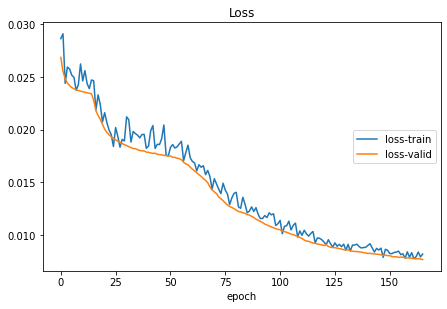

Loss
	loss-train       	 (min:    0.008, max:    0.029, cur:    0.008)
	loss-valid       	 (min:    0.008, max:    0.027, cur:    0.008)
Iter: 166/1000, Training Loss: 0.008203175850212574, Validation Loss: 0.0076873875223100185


KeyboardInterrupt: ignored

In [0]:
RNN2_LEARNING_RATE = 0.0001
RNN2_TRAIN_ITERATIONS = 1000
RNN2_BATCH_SIZE = 128
RNN2_TRAIN_SAMPLES = 4096
RNN2_VALID_SAMPLES = 256
RNN2_SEQ_LENGTH = 300
RNN2_MODEL_PATH = './rnn2.pt'

RNN2_ENC_DIM = ENCODER_PLACE_CELLS
RNN2_HIDDEN_DIM = 128
RNN2_PROJ_DIM = 128

RNN2_DROPOUT = 0.5

class RNN2Model(nn.Module):

    def __init__(self, enc_dim, hidden_dim, proj_dim, dropout):
        super(RNN2Model, self).__init__()  
        self.enc_dim = enc_dim    
        self.hidden_dim = hidden_dim  
        self.proj_dim = proj_dim  
        self.start_to_hidden_layer = nn.Linear(enc_dim, hidden_dim)
        self.gru_layer = nn.GRU(input_size=1, hidden_size=hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, proj_dim)
        self.hidden_to_output = nn.Linear(proj_dim, enc_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() 
        self.dropout = nn.Dropout(dropout)

    """
    start is of size:   (BATCH_SIZE, ENC_DIM)
    states if of size:  (SEQ_LENGTH, BATCH_SIZE, HIDDEN_DIM)
    outputs if of size: (SEQ_LENGTH, BATCH_SIZE, ENC_DIM)
    """
    def forward(self, start, inputs):
        hidden = self.start_to_hidden_layer(start).unsqueeze(0)
        states, state = self.gru_layer(inputs, hidden) 
        states = self.dropout(states)
        #states = self.relu(states)
        projection = self.hidden_to_hidden(states)
        projection = self.dropout(projection)
        outputs = self.hidden_to_output(projection)
        return outputs, states, projection

rnn2_model = RNN2Model(RNN2_ENC_DIM, RNN2_HIDDEN_DIM, RNN2_PROJ_DIM, RNN2_DROPOUT)
rnn2_model.to(dev)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn2_model.parameters(), lr=RNN2_LEARNING_RATE)
rnn2_dataset = DecoderDataset(encoder, RNN2_TRAIN_SAMPLES + RNN2_VALID_SAMPLES)
rnn2_train_set, rnn2_valid_set = torch.utils.data.random_split(
    rnn2_dataset, 
    [RNN2_TRAIN_SAMPLES, RNN2_VALID_SAMPLES]
)
rnn2_train_loader = torch.utils.data.DataLoader(
    rnn2_train_set, 
    batch_size=RNN2_BATCH_SIZE, 
    shuffle=True
)
rnn2_val_loader = torch.utils.data.DataLoader(
    rnn2_valid_set, 
    batch_size=RNN2_BATCH_SIZE, 
    shuffle=False
)

rnn2_plotlosses = PlotLosses(groups={'Loss': ['loss-train', 'loss-valid']})

for iter in range(RNN2_TRAIN_ITERATIONS):
    loss_train = None 
    loss_valid = None

    for idx, (pos, enc_pos) in enumerate(rnn2_train_loader):
        enc_pos = enc_pos.float().to(dev)
        inputs = torch.zeros((RNN2_SEQ_LENGTH, RNN2_BATCH_SIZE, 1)).float().to(dev)
        optimizer.zero_grad()
        pos_encoded_predicted, hidden, proj = rnn2_model(enc_pos, inputs)
        loss_train = criterion(pos_encoded_predicted.view(-1), enc_pos.repeat(RNN2_SEQ_LENGTH,1,1).view(-1)) 
        loss_train.backward()
        optimizer.step() 
    
    for idx, (pos, enc_pos) in enumerate(rnn2_val_loader):
        enc_pos = enc_pos.float().to(dev)
        inputs = torch.zeros((RNN2_SEQ_LENGTH, RNN2_BATCH_SIZE, 1)).float().to(dev)
        pos_encoded_predicted, _, _ = rnn2_model(enc_pos, inputs)
        loss_valid = criterion(pos_encoded_predicted.view(-1), enc_pos.repeat(RNN2_SEQ_LENGTH,1,1).view(-1)) 

    rnn2_plotlosses.update({'loss-train': loss_train.item(), 'loss-valid': loss_valid.item()})
    rnn2_plotlosses.send()
    if(iter % 5 == 0):
        print('Iter: %s/%s, Training Loss: %s, Validation Loss: %s' % (
            iter+1, 
            RNN2_TRAIN_ITERATIONS, 
            loss_train.item(), 
            loss_valid.item()
            )
        )

torch.save(rnn2_model.state_dict(), RNN2_MODEL_PATH)

In [0]:
"""
Example: we encode a single position and then decode it using our decoder model. 
"""
position = [0.1, 0.9] 
position_encoded = torch.Tensor(encoder.encode_positions([position])[0]).float().to(dev).unsqueeze(0)
inputs = torch.zeros((RNN2_SEQ_LENGTH, 1, 1)).float().to(dev)
pos_encoded_predicted, _, _ = rnn2_model(position_encoded, inputs)
position_predicted, _ = decoder_model(pos_encoded_predicted)
print(position_predicted)

tensor([[[ 2.8924e-01,  1.0757e+00]],

        [[ 3.6700e-01,  6.3919e-01]],

        [[ 2.6528e-01,  4.4497e-01]],

        [[-2.9946e-02,  8.5245e-01]],

        [[ 1.2065e-01,  7.8937e-01]],

        [[-1.2582e-01,  7.6691e-01]],

        [[ 1.2478e-02,  8.4455e-01]],

        [[ 3.0029e-01,  8.5036e-01]],

        [[ 3.1869e-01,  9.0847e-01]],

        [[ 2.2481e-01,  6.4686e-01]],

        [[ 1.7594e-01,  8.3459e-01]],

        [[ 2.2709e-01,  6.5038e-01]],

        [[ 1.5170e-01,  1.0084e+00]],

        [[ 1.6626e-01,  7.7534e-01]],

        [[ 3.0379e-01,  1.0744e+00]],

        [[ 2.5244e-01,  1.1073e+00]],

        [[ 1.0720e-01,  6.6976e-01]],

        [[ 3.5484e-01,  5.0691e-01]],

        [[ 2.6466e-01,  9.0852e-01]],

        [[ 2.6700e-01,  8.9199e-01]],

        [[ 3.5729e-01,  8.4328e-01]],

        [[ 1.5990e-01,  6.6007e-01]],

        [[ 2.3864e-01,  7.7392e-01]],

        [[ 1.1897e-01,  8.9423e-01]],

        [[ 5.5294e-02,  6.5828e-01]],

        [[ 3.2040e-01,  7

torch.Size([10000, 96])
Evaluating activation rates...
Unit 1/128
Unit 2/128
Unit 3/128
Unit 4/128
Unit 5/128
Unit 6/128
Unit 7/128
Unit 8/128
Unit 9/128
Unit 10/128
Unit 11/128
Unit 12/128
Unit 13/128
Unit 14/128
Unit 15/128
Unit 16/128
Unit 17/128
Unit 18/128
Unit 19/128
Unit 20/128
Unit 21/128
Unit 22/128
Unit 23/128
Unit 24/128
Unit 25/128
Unit 26/128
Unit 27/128
Unit 28/128
Unit 29/128
Unit 30/128
Unit 31/128
Unit 32/128
Unit 33/128
Unit 34/128
Unit 35/128
Unit 36/128
Unit 37/128
Unit 38/128
Unit 39/128
Unit 40/128
Unit 41/128
Unit 42/128
Unit 43/128
Unit 44/128
Unit 45/128
Unit 46/128
Unit 47/128
Unit 48/128
Unit 49/128
Unit 50/128
Unit 51/128
Unit 52/128
Unit 53/128
Unit 54/128
Unit 55/128
Unit 56/128
Unit 57/128
Unit 58/128
Unit 59/128
Unit 60/128
Unit 61/128
Unit 62/128
Unit 63/128
Unit 64/128
Unit 65/128
Unit 66/128
Unit 67/128
Unit 68/128
Unit 69/128
Unit 70/128
Unit 71/128
Unit 72/128
Unit 73/128
Unit 74/128
Unit 75/128
Unit 76/128
Unit 77/128
Unit 78/128
Unit 79/128
Unit 8

array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.001, 0.   , 0.001],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0. 

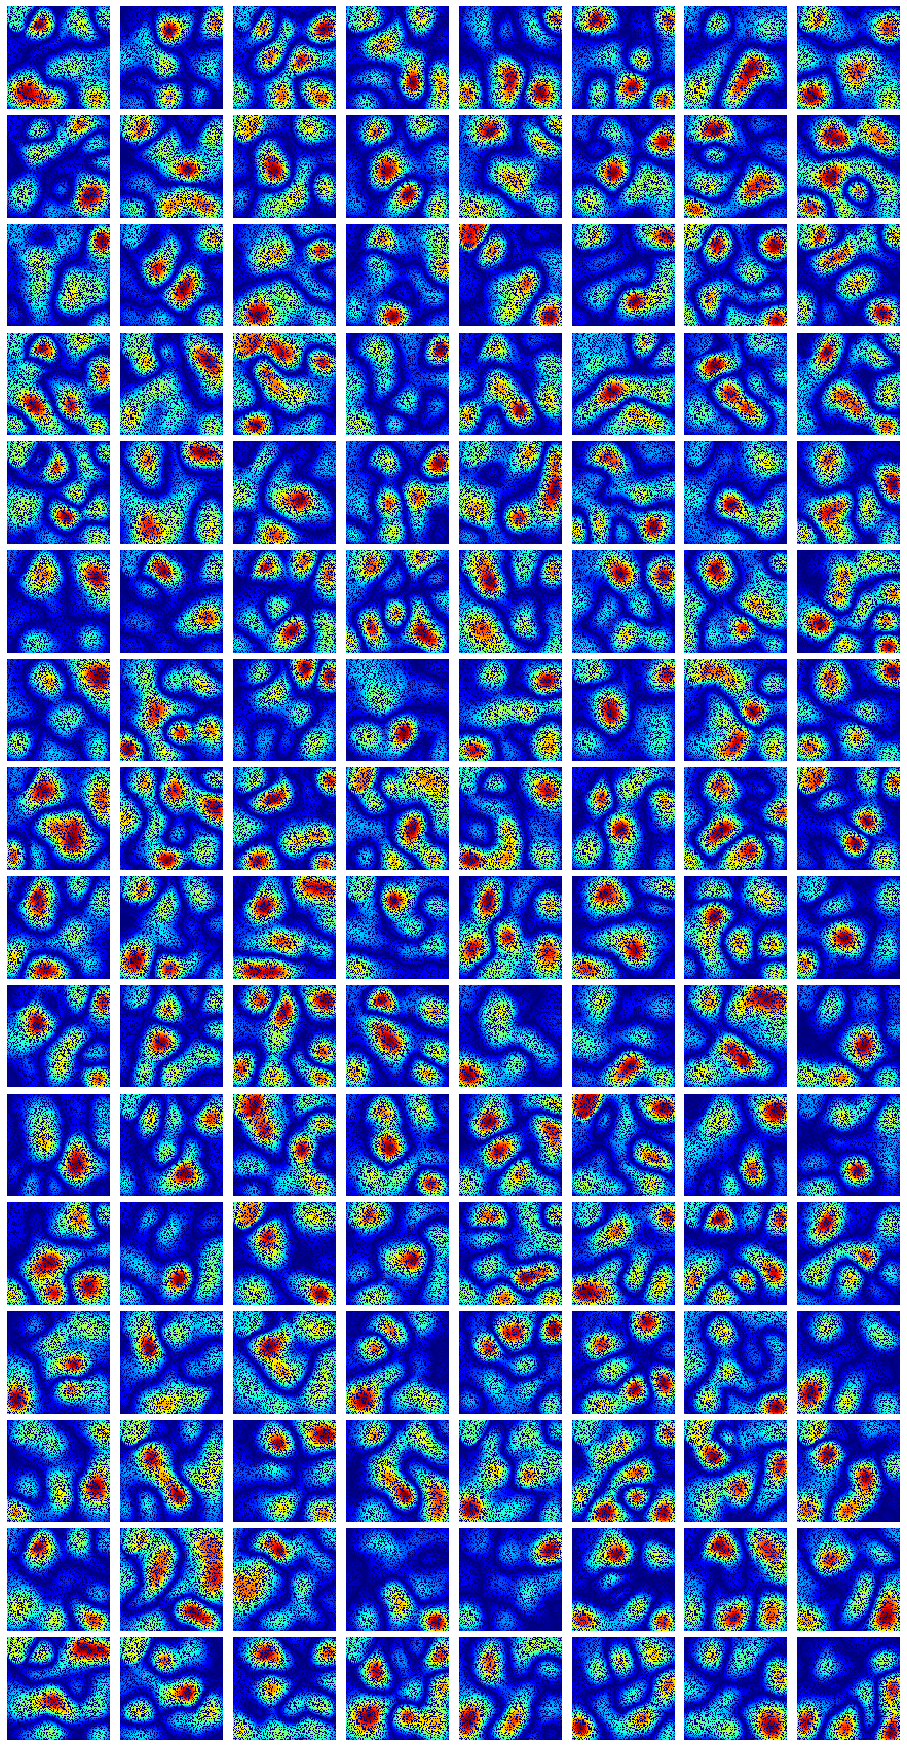

In [0]:
rnn2_model.eval()
# Check activations of hidden units
torch.cuda.empty_cache()
RNN2_VISUALIZATION_NUM_SAMPLES = 10000 # Number of paths of length RNN_SEQ_LENGTH to generate.

rnn2_visualization_dataset = DecoderDataset(encoder, RNN2_VISUALIZATION_NUM_SAMPLES)
rnn2_visualization_loader = torch.utils.data.DataLoader(rnn2_visualization_dataset, batch_size=RNN2_VISUALIZATION_NUM_SAMPLES)

idx, (pos, enc_pos) = list(enumerate(rnn2_visualization_loader))[0]
enc_pos = enc_pos.float().to(dev)

print(enc_pos.shape)
inputs = torch.zeros((RNN2_SEQ_LENGTH, RNN2_VISUALIZATION_NUM_SAMPLES, 1)).float().to(dev)
pos_encoded_predicted, hidden_layer, projection_layer = rnn2_model(enc_pos, inputs)

pos = pos.reshape(-1, 2).detach().cpu().numpy()
pos_encoded_predicted = pos_encoded_predicted[RNN2_SEQ_LENGTH-1].view(-1, RNN2_ENC_DIM).detach().cpu().numpy()
hidden_layer = hidden_layer[RNN2_SEQ_LENGTH-1].view(-1, RNN2_HIDDEN_DIM).detach().cpu().numpy()
projection_layer = projection_layer[RNN2_SEQ_LENGTH-1].view(-1, RNN2_PROJ_DIM).detach().cpu().numpy()

firing_visualizer.visualize(pos, projection_layer, "")